# Neural Network Starter for NCAA March Madness
![](https://upload.wikimedia.org/wikipedia/en/thumb/2/28/March_Madness_logo.svg/440px-March_Madness_logo.svg.png)
#### Credits - [https://www.kaggle.com/hiromoon166/2020-women-s-starter-kernel](https://www.kaggle.com/hiromoon166/2020-women-s-starter-kernel)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from sklearn.utils import shuffle

## Reading .csv Files
* Compact Results - Winner/Loser, Points, etc
* Seeds - A seed is a competitor or team in a sport or other tournament who is given a preliminary ranking for the purposes of the draw.
* Season Results - Total Points throughout the seasons

In [2]:
res = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WDataFiles_Stage1/WNCAATourneyCompactResults.csv')
seed = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WDataFiles_Stage1/WNCAATourneySeeds.csv')

season_res = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WDataFiles_Stage1/WRegularSeasonCompactResults.csv')

test = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WSampleSubmissionStage1_2020.csv')

In [3]:
season_res.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1998,18,3104,91,3202,41,H,0
1,1998,18,3163,87,3221,76,H,0
2,1998,18,3222,66,3261,59,H,0
3,1998,18,3307,69,3365,62,H,0
4,1998,18,3349,115,3411,35,H,0


## Utility function for preprocessing
1. Match Teams with their respective seed
2. Match Teams with their season scores

In [4]:
def prepare(df, seed, season_score):
    merged = pd.merge(df, seed, left_on = ['Season', 'WTeamID'], right_on = ['Season', 'TeamID'], how = 'left')
    merged.rename(columns = {'Seed':'WSeed'}, inplace = True)
    merged.drop(['TeamID'], axis = 1, inplace = True)
    merged = pd.merge(merged, seed, left_on = ['Season', 'LTeamID'], right_on = ['Season', 'TeamID'], how = 'left')
    merged.rename(columns = {'Seed':'LSeed'}, inplace = True)
    merged.drop(['TeamID'], axis = 1, inplace = True)
    
    merged['WSeed'] = merged['WSeed'].apply(lambda x: int(x[1:3]))
    merged['LSeed'] = merged['LSeed'].apply(lambda x: int(x[1:3]))
    
    merged = pd.merge(merged, season_score, left_on = ['Season', 'WTeamID'], right_on = ['Season', 'TeamID'], how = 'left')
    merged.rename(columns = {'Score':'WScoreT'}, inplace = True)
    merged.drop(['TeamID'], axis = 1, inplace = True)
    merged = pd.merge(merged, season_score, left_on = ['Season', 'LTeamID'], right_on = ['Season', 'TeamID'], how = 'left')
    merged.rename(columns = {'Score':'LScoreT'}, inplace = True)
    merged.drop(['TeamID'], axis = 1, inplace = True)
    
    return merged

In [5]:
# Drop irrelevant columns
res.drop(['DayNum', 'NumOT', 'WLoc', 'WScore', 'LScore'], axis = 1, inplace = True)

In [6]:
season_res_w = season_res[['Season', 'WScore', 'WTeamID']]
season_res_l = season_res[['Season', 'LScore', 'LTeamID']]
season_res_w.rename(columns = {'WScore':'Score', 'WTeamID':'TeamID'}, inplace = True)
season_res_l.rename(columns = {'LScore':'Score', 'LTeamID':'TeamID'}, inplace = True)
season_res = pd.concat((season_res_w, season_res_l)).reset_index(drop = True)
season_score = season_res.groupby(['Season', 'TeamID']).sum().reset_index()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [7]:
# Extracting Season, Winning Team Id, Losing Team Id form test csv file
test['Season'] = test['ID'].map(lambda x: int(x[:4]))
test['WTeamID'] = test['ID'].map(lambda x: int(x[5:9]))
test['LTeamID'] = test['ID'].map(lambda x: int(x[10:14]))

## Preprocessing

In [8]:
df = prepare(res, seed, season_score)
df_test = prepare(test, seed, season_score)

In [9]:
df.drop(['Season', 'WTeamID', 'LTeamID'], inplace = True, axis = 1)
df_test.drop(['ID', 'Season', 'WTeamID', 'LTeamID'], inplace = True, axis = 1)

## Labelling Training Data

In [10]:
wins = df
loss = wins.copy()

loss['WSeed'] = wins['LSeed']
loss['LSeed'] = wins['WSeed']
loss['WScoreT'] = wins['LScoreT']
loss['LScoreT'] = wins['WScoreT']

wins['Margin'] = wins['WScoreT'] - wins['LScoreT']
loss['Margin'] = loss['WScoreT'] - loss['LScoreT']
wins['Margin_seed'] = wins['WSeed'] - wins['LSeed']
loss['Margin_seed'] = loss['WSeed'] - loss['LSeed']

wins['result'] = 1
loss['result'] = 0

train = pd.concat((wins, loss)).reset_index(drop = True)
x_train = train.drop(['result'], axis = 1)
y_train = train['result']

In [11]:
# Shuffle to avoid bias
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)

In [12]:
# Extracting additionsl features
df_test['Margin'] = df_test['WScoreT'] - df_test['LScoreT']
df_test['Margin_seed'] = df_test['WSeed'] - df_test['LSeed']

In [13]:
df_test.drop(['Pred'], axis = 1, inplace = True)

## Scaling Score data 

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train['WScoreT'] = scaler.fit_transform(x_train['WScoreT'].to_numpy().reshape(-1, 1))
x_train['LScoreT'] = scaler.fit_transform(x_train['LScoreT'].to_numpy().reshape(-1, 1))

df_test['WScoreT'] = scaler.fit_transform(df_test['WScoreT'].to_numpy().reshape(-1, 1))
df_test['LScoreT'] = scaler.fit_transform(df_test['LScoreT'].to_numpy().reshape(-1, 1))

In [15]:
model = tf.keras.models.Sequential([ 
    tf.keras.layers.Dense(128, input_shape=(6,), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),     
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1

In [16]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(0.0001))

In [17]:
history = model.fit(x_train, y_train,
                    epochs=100,
                    verbose=0)

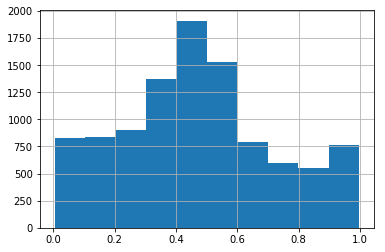

In [18]:
# Prediction

y_test = model.predict(df_test)

sub = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WSampleSubmissionStage1_2020.csv')

sub['Pred'] = y_test
sub['Pred'].hist()

In [19]:
sub.to_csv('submission.csv', index = False)